In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ['ENABLE_PJRT_COMPATIBILITY'] = "1"
os.environ['JAX_DISABLE_JIT'] = "1"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras
import einops

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
print(jax.__version__)
# tf.config.optimizer.set_jit(True)

2.16.1
0.4.30


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
# train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,99)]
# random.shuffle(train_files)
# valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(99, 102)]
DATA_TFREC = "data"
# create list of all tfrec files in folder and sub folders
TFREC_FILES = tf.io.gfile.glob(DATA_TFREC + '/**/*.tfrec')
TFREC_FILES = sorted(TFREC_FILES, key=lambda x: os.path.basename(x))
print(len(TFREC_FILES))
train_files = TFREC_FILES[1:98]
valid_files = TFREC_FILES[98:]
train_options = tf.data.Options()
train_options.deterministic = True

sequence_length = 256
BATCH_SIZE = sequence_length * 4

def filter_valid_batch(x, y):
    batch_size = tf.shape(x)[0]
    valid_x = tf.equal(batch_size * 556 % (sequence_length * 556), 0)
    valid_y = tf.equal(batch_size * 368 % (sequence_length * 368), 0)
    return tf.logical_and(valid_x, valid_y)

def add_sequence_dim(x, y):
    x = tf.reshape(x, (-1, sequence_length, 556))
    y = tf.reshape(y, (-1, sequence_length, 368))
    return x, y

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']


ds_train = (
  tf.data.TFRecordDataset(train_files)
    .with_options(train_options)
  .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .filter(lambda x, y: filter_valid_batch(x, y))
    .map(add_sequence_dim, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .filter(lambda x, y: filter_valid_batch(x, y))
    .map(add_sequence_dim, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

101


In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB



W0000 00:00:1720109164.259739 16372811 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1720109164.259983 16372811 service.cc:145] XLA service 0x30ebfe580 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720109164.259992 16372811 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1720109164.261292 16372811 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1720109164.261301 16372811 mps_client.cc:384] XLA backend will use up to 77309001728 bytes on device 0 for SimpleAllocator.
2024-07-04 17:06:20.012113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-07-04 17:06:35.025562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# mean_y = tf.cast(mean_y, tf.float64)
# stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
# min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
# max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

In [11]:
# min_y = tf.cast(min_y, tf.float64)
# max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [13]:
epochs = 4
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE * 4))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [14]:
import keras
import tensorflow as tf

HEIGHT = 60
WIDTH = 25

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, :, 0:60 * 6], (-1, sequence_length, 6, 60)), (0, 1, 3, 2))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, :, 60 * 6 + 16:60 * 9 + 16], (-1, sequence_length, 3, 60)), (0, 1, 3, 2))
    x_flat = keras.ops.reshape(x[:, :, 60 * 6:60 * 6 + 16], (-1, sequence_length, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=2)
    concat = keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)
    # add a channel dimension
    return keras.ops.expand_dims(concat, -1)

class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        keras.layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        keras.layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        keras.layers.LayerNormalization(),
        keras.layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        keras.layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        keras.layers.Dense(units),
        keras.layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return keras.layers.add([res, out])

class ResizeSeries(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = keras.layers.Resizing(self.height, self.width)

  def call(self, timseries):
    """
      Use the einops library to resize the tensor.  

      Args:
        timseries: Tensor representation of the timseries, in the form of a set of frames.

      Return:
        A downsampled size of the timseries according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(timseries, 'b t h w c')
    images = einops.rearrange(timseries, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    timserieses = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return timserieses

# input_shape = (None, sequence_length, HEIGHT, WIDTH, 1)
input = keras.layers.Input((None, 556))
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(input)
x = x_to_seq(input)

x = Conv2Plus1D(filters=32, kernel_size=(7, 3, 3), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

# Block 1
# x = add_residual_block(x, 512, (3, 3, 3))

# Block 2
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeSeries(HEIGHT // 2, WIDTH // 2)(x)

# x = x0 = ...
# Block 3
x = x0 = add_residual_block(x, 128, (3, 3, 3))
# x = ResizeSeries(HEIGHT // 4, WIDTH // 4)(x)

# pooling here
# x = x + x0 + pooling
# maybe also resize from top again
# Block 4
x = x0 + add_residual_block(x, 128, (3, 3, 3)) + keras.layers.GlobalAveragePooling3D(keepdims = True)(x)
x = ResizeSeries(HEIGHT // 4, WIDTH // 4)(x)

x = add_residual_block(x, 256, (3, 3, 3))
x = ResizeSeries(HEIGHT // 6, WIDTH // 6)(x)

# Block 5
x = add_residual_block(x, 368, (3, 3, 3))
x = ResizeSeries(1, 1)(x)

# reshape to 1D
x = keras.layers.Reshape((-1, 1, 1, sequence_length*368))(x)

# reshape to sequence_length, 368
x = keras.layers.Reshape((sequence_length, 368))(x)


# rid the channel dimension
# x = keras.layers.Reshape((128, 1500))(x)

# conv1d
# x = keras.layers.Conv1D(368, 1, activation='linear')(x)

model = keras.Model(input, x)

model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler, 
                                    ),
    # metrics=[ClippedR2Score()]
)

model.build(input_shape=(None, None, 556))
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 556) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None, 360) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None, 180) │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None, 16)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 6,    │          0 │ get_item[0][0]    │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 256, 3,    │          0 │ get_item_1[0][0]  │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 256, 1,    │          0 │ get_item_2[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 256, 60,   │          0 │ reshape[0][0]     │
│ (Transpose)         │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 256, 60,   │          0 │ reshape_1[0][0]   │
│ (Transpose)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 256, 60,   │          0 │ reshape_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 60,   │          0 │ transpose[0][0],  │
│ (Concatenate)       │ 25)               │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 256, 60,   │          0 │ concatenate[0][0] │
│ (ExpandDims)        │ 25, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_plus1d        │ (None, 256, 60,   │      7,520 │ expand_dims[0][0] │
│ (Conv2Plus1D)       │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 60,   │        128 │ conv2_plus1d[0][… │
│ (BatchNormalizatio… │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 60,   │          0 │ batch_normalizat… │
│                     │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project (Project)   │ (None, 256, 60,   │      2,240 │ re_lu[0][0]       │
│                     │ 25, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main       │ (None, 256, 60,   │     80,384 │ re_lu[0][0]     

 Total params: 5,104,624 (19.47 MB)

 Trainable params: 5,104,560 (19.47 MB)

 Non-trainable params: 64 (256.00 B)

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
%load_ext tensorboard
import datetime

log_dir = "logs/train/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/3dcnn.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
        tensorboard_callback,
    ]
)

Epoch 1/4


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3cd88eea0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57abc3770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      1/Unknown 19s 19s/step - loss: 2.5905

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57bcd1850>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57bfbeeb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      2/Unknown 34s 15s/step - loss: 2.4002

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e2c632d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ed09fdf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      3/Unknown 50s 15s/step - loss: 2.2341

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e294ba50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3edc2f370>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      4/Unknown 63s 15s/step - loss: 2.0973

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e4fd5c70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e4ecbeb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      5/Unknown 79s 15s/step - loss: 1.9910

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e5561f00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e5336770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      6/Unknown 91s 14s/step - loss: 1.9001

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e56411f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ea2bd890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      7/Unknown 107s 15s/step - loss: 1.8217

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e5d28b00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e5d2b590>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      8/Unknown 123s 15s/step - loss: 1.7538

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e5def890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e813c6b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

      9/Unknown 137s 15s/step - loss: 1.6950

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e8d776a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e71e53e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     10/Unknown 152s 15s/step - loss: 1.6437

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e67b89e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e758fca0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     11/Unknown 168s 15s/step - loss: 1.5981

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ea57b900>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e992df90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     12/Unknown 184s 15s/step - loss: 1.5581

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e9c50cc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e9c75270>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     13/Unknown 199s 15s/step - loss: 1.5223

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3eb84a3c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ea934ed0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     14/Unknown 215s 15s/step - loss: 1.4900

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3e8f838a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ed768830>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     15/Unknown 232s 15s/step - loss: 1.4609

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x577cddb60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x58248ae80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     16/Unknown 251s 15s/step - loss: 1.4342

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3edfd8c80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x58263d3d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     17/Unknown 269s 16s/step - loss: 1.4098

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ecd8a7b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ecd8e0e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     18/Unknown 289s 16s/step - loss: 1.3874

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x44c06d8a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x44c45d390>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     19/Unknown 304s 16s/step - loss: 1.3667

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x583907de0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x44c1075b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     20/Unknown 324s 16s/step - loss: 1.3475

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3ebe7d6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57ef41b70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     21/Unknown 342s 16s/step - loss: 1.3293

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57f0490e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57d79c550>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     22/Unknown 360s 16s/step - loss: 1.3121

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x58070d1c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57c482c50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     23/Unknown 378s 16s/step - loss: 1.2959

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57d21a870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x583a40dc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     24/Unknown 395s 16s/step - loss: 1.2807

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x5804e0700>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     27/Unknown 454s 17s/step - loss: 1.2402

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57f671bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57f674090>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     29/Unknown 490s 17s/step - loss: 1.2172

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x580f91890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     30/Unknown 509s 17s/step - loss: 1.2067

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x586516530>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x5864215a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     31/Unknown 527s 17s/step - loss: 1.1968

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x57d985560>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x58a5ead20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     32/Unknown 546s 17s/step - loss: 1.1874

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d5570d70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     33/Unknown 564s 17s/step - loss: 1.1785

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d5997ee0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d49ff5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     34/Unknown 580s 17s/step - loss: 1.1698

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d4c40580>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     35/Unknown 598s 17s/step - loss: 1.1616

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d5278400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     36/Unknown 616s 17s/step - loss: 1.1537

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d7e0cfb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d8672a50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     38/Unknown 654s 17s/step - loss: 1.1388

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d94146d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8d9409050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     39/Unknown 670s 17s/step - loss: 1.1317

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a687a2a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8dc944e00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     43/Unknown 746s 17s/step - loss: 1.1056

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a64fef90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a7940270>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     44/Unknown 763s 17s/step - loss: 1.0995

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a7af9a00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     45/Unknown 782s 17s/step - loss: 1.0937

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a7c9fac0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9a7153730>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     46/Unknown 799s 17s/step - loss: 1.0880

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8dc7f55b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e6145f90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     47/Unknown 817s 17s/step - loss: 1.0824

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e6f0d650>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ed83bb10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     48/Unknown 834s 17s/step - loss: 1.0770

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e7207e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e70d6bb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     49/Unknown 852s 17s/step - loss: 1.0717

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e837c8e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e836f520>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     50/Unknown 870s 17s/step - loss: 1.0665

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x585e36d50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9e9b57b30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     51/Unknown 888s 17s/step - loss: 1.0615

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9eb1f13e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9eb8b34b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     52/Unknown 905s 17s/step - loss: 1.0566

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ea872400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ea7a0aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     55/Unknown 962s 17s/step - loss: 1.0426

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ed9c1380>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ecb84a10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

     56/Unknown 977s 17s/step - loss: 1.0382

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ee8687d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


     57/Unknown 995s 17s/step - loss: 1.0339

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9ee589910>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1553/Unknown 27419s 18s/step - loss: 0.7449

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9c58cc30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9c56bbe0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1554/Unknown 27429s 18s/step - loss: 0.7449

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9b005860>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1555/Unknown 27446s 18s/step - loss: 0.7448

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9dcc4130>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9d949160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1556/Unknown 27462s 18s/step - loss: 0.7448

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xce07c6780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9f9442d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1557/Unknown 27478s 18s/step - loss: 0.7448

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9f49cb20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1558/Unknown 27495s 18s/step - loss: 0.7447

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea067dd40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea1c2c000>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1561/Unknown 27545s 18s/step - loss: 0.7446

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f4b4faa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1562/Unknown 27562s 18s/step - loss: 0.7446

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f679e750>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1563/Unknown 27579s 18s/step - loss: 0.7446

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f5b0ee50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1564/Unknown 27596s 18s/step - loss: 0.7446

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f6d5bb70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f761b7b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1565/Unknown 27612s 18s/step - loss: 0.7445

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f6a58570>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f80975d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1566/Unknown 27626s 18s/step - loss: 0.7445

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f8154b40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f72d1680>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1567/Unknown 27643s 18s/step - loss: 0.7445

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f779bc00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1568/Unknown 27660s 18s/step - loss: 0.7444

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9edb5750>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea9bfa590>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1569/Unknown 27675s 18s/step - loss: 0.7444

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xe9efb4520>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1570/Unknown 27692s 18s/step - loss: 0.7444

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f451df30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f4521970>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1571/Unknown 27709s 18s/step - loss: 0.7444

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea6773440>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1572/Unknown 27726s 18s/step - loss: 0.7443

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea688ee40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea5288600>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1573/Unknown 27742s 18s/step - loss: 0.7443

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea7eb89a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1574/Unknown 27759s 18s/step - loss: 0.7443

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea7620be0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1575/Unknown 27776s 18s/step - loss: 0.7442

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea81c9db0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea6a0ab50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1576/Unknown 27791s 18s/step - loss: 0.7442

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea8ef1d50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea6c470d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1577/Unknown 27808s 18s/step - loss: 0.7442

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeaa42f150>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x9f4835630>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1578/Unknown 27825s 18s/step - loss: 0.7441

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xea93b7690>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1580/Unknown 27860s 18s/step - loss: 0.7441

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeabccedd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeac9150b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1582/Unknown 27892s 18s/step - loss: 0.7440

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeaeb34d80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1584/Unknown 27927s 18s/step - loss: 0.7440

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb065a350>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeac294280>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1586/Unknown 27960s 18s/step - loss: 0.7439

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeaf88aa60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeaefac6d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1587/Unknown 27975s 18s/step - loss: 0.7439

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb773a7a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   1588/Unknown 27992s 18s/step - loss: 0.7439

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb851b6d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb016a060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   1590/Unknown 28026s 18s/step - loss: 0.7438

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb6f569c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3643/Unknown 64323s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751916b6c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7507309300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3644/Unknown 64339s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751db12d80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750608dfd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3645/Unknown 64354s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750a530b10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x71a8b5f450>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3646/Unknown 64370s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7509fea6d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750a8ae990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3647/Unknown 64385s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750b3953f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750b3bb800>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3648/Unknown 64401s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750bccf500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750846d300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3649/Unknown 64417s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75106f1730>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750a957770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3650/Unknown 64433s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750e9099b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3651/Unknown 64450s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75068e0460>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750ae82300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3652/Unknown 64466s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750e87de70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3653/Unknown 64483s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7506fc7dc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750e169280>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3654/Unknown 64500s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750f74b430>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7506efa190>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3655/Unknown 64515s 18s/step - loss: 0.7160

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750f985140>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7510714180>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3656/Unknown 64531s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751140dda0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750c9dd2b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3657/Unknown 64546s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75112eb6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75107b15b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3658/Unknown 64561s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75135592a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3659/Unknown 64578s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb1d16450>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb1d0d180>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   3660/Unknown 64595s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb6275e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb3067640>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   3661/Unknown 64609s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb1f63610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb3667870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   3662/Unknown 64624s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb4e57a10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb4e79470>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   3663/Unknown 64640s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb580ec20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb580d920>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    r

   3664/Unknown 64655s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x750964df50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3665/Unknown 64672s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7510e91b90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7511e7c620>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3666/Unknown 64687s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7512228480>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7515961300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3667/Unknown 64702s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751251fba0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75125290e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3668/Unknown 64719s 18s/step - loss: 0.7159

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7512487eb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7516428300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3669/Unknown 64733s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7514b95270>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3670/Unknown 64750s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75138fbb70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3671/Unknown 64767s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7515ddaee0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7517a77c20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3672/Unknown 64782s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7515ffee00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7515171bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3673/Unknown 64797s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7518edac50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7518e3e770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3674/Unknown 64812s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75167673a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751676ade0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3676/Unknown 64845s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7517cbbc80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7519754490>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3677/Unknown 64860s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7517da7010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7517559b70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3678/Unknown 64876s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751cdfd390>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0xeb6448150>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    

   3679/Unknown 64891s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751b80e950>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7519ded530>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3680/Unknown 64907s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751d7a1410>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751e518290>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3681/Unknown 64918s 18s/step - loss: 0.7158

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751ca6c4b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751c5aa010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3682/Unknown 64933s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751f88bd30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751f36cba0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3684/Unknown 64965s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751ec7a6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751dfc1b50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3685/Unknown 64981s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7521bc2400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75209143a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3686/Unknown 64997s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7526f30510>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7522fc6a70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3687/Unknown 65012s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751ab84440>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75222df110>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3688/Unknown 65025s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x751a2e37d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75217cb840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3689/Unknown 65040s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75224130b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7522435f70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3690/Unknown 65057s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7520011400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7523af4c10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3691/Unknown 65072s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7525d0b200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7524ea68f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3692/Unknown 65088s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75232ca9b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75232be060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3693/Unknown 65103s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752213a320>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7520758dc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3694/Unknown 65118s 18s/step - loss: 0.7157

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7525cfdf50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7521e24fa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3695/Unknown 65133s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7529cd0660>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7529ca97e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3696/Unknown 65149s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75275cc9b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752805ebf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3697/Unknown 65164s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7528904eb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75292b0d60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3698/Unknown 65180s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7529825370>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7529be1010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3699/Unknown 65193s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7530fd3090>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75310857f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3700/Unknown 65206s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752a3f0840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7524c1fc10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3701/Unknown 65223s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752a1d17d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752b70a1f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3702/Unknown 65239s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752c4aa100>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752e03c060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3703/Unknown 65253s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752d7f59b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3704/Unknown 65270s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752e2098c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752ce19440>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3705/Unknown 65287s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752b230460>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752bd785e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3706/Unknown 65303s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752b36cfb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752b524ca0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3707/Unknown 65318s 18s/step - loss: 0.7156

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752fa29400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752d1a3a50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3708/Unknown 65334s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752d21c4e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3709/Unknown 65351s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752f42fd40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   3710/Unknown 65368s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7534609a20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7534168a40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3711/Unknown 65383s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7533c383c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75356ff4f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3712/Unknown 65396s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752f6524a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7534563c30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3713/Unknown 65412s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75324ddcc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75324df400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3714/Unknown 65427s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7537083890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7534c06580>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3716/Unknown 65460s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75394107a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75391f2740>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3717/Unknown 65477s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753ad07a40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7538129b30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3718/Unknown 65492s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753ba17920>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753b8ce6f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3719/Unknown 65507s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753a5d1260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753c1887f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3720/Unknown 65523s 18s/step - loss: 0.7155

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753be18160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753bf6eb50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3721/Unknown 65538s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753daa5360>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753b144eb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3722/Unknown 65554s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753f232ec0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753c5f6ad0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3723/Unknown 65570s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7531a35160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753eee1d40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3724/Unknown 65586s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753f343360>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753e231590>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3725/Unknown 65600s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x752af0f3e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753d9ffb60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3726/Unknown 65615s 18s/step - loss: 0.7154

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x753ca7b010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7546f62960>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3748/Unknown 66008s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7556a6c160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7557424de0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3749/Unknown 66025s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75585f6160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755089c470>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3750/Unknown 66039s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755d468cd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7558411d10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3751/Unknown 66054s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75556cdf20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7547222580>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3752/Unknown 66069s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755d1df0b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7541240540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3754/Unknown 66102s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75437e3020>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7542968d50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3755/Unknown 66117s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7544907ef0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7542f302c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3756/Unknown 66132s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7551b63330>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7551b5e5a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3757/Unknown 66149s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7555888f80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7542e82f10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3758/Unknown 66164s 18s/step - loss: 0.7152

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75542ce6c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75542e6f20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3759/Unknown 66179s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75592837c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7559240110>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3760/Unknown 66195s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755adbd510>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755afaf480>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3761/Unknown 66211s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7557c71570>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7557c5c950>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3762/Unknown 66224s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7544361160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755bc6f4c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3763/Unknown 66241s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7559f99ab0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7559f915d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3764/Unknown 66257s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755a3a3bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755f9a3410>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3765/Unknown 66272s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755c7d4770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7557b2ea00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3766/Unknown 66288s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7557a3e1f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755ee9c200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3767/Unknown 66303s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755f21f8d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755dbdda10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3768/Unknown 66318s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7560230000>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755df34630>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3769/Unknown 66334s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7562aaaf70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7562ae5d70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3770/Unknown 66348s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755fea9cf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x755e7e9a90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3771/Unknown 66364s 18s/step - loss: 0.7151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7562f90580>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7562fa5010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3772/Unknown 66378s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756201eb70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75612a5fa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3773/Unknown 66393s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75635336d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75635375c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3774/Unknown 66407s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7544c28660>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7561f042f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3775/Unknown 66423s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75654ecee0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75657d12b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3776/Unknown 66440s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75646232e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7563aee6c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3777/Unknown 66454s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75663e1330>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7566c0d250>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3778/Unknown 66469s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x757f996980>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7566755010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3779/Unknown 66484s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7567f3d060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7567f58cc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3780/Unknown 66499s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75715725e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7571588350>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3781/Unknown 66515s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x75694138b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7568c0cde0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3783/Unknown 66548s 18s/step - loss: 0.7150

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7568743ee0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756bc9eb70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3784/Unknown 66563s 18s/step - loss: 0.7149

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756d7fdad0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756d7e4200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3785/Unknown 66579s 18s/step - loss: 0.7149

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756c71aa60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756c814070>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3786/Unknown 66592s 18s/step - loss: 0.7149

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756a88fb90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756d69c760>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   3787/Unknown 66609s 18s/step - loss: 0.7149

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756d04f560>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x756f1d38c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4454/Unknown 78634s 18s/step - loss: 0.7094

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776be880e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4455/Unknown 78651s 18s/step - loss: 0.7094

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776b3c92a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776b3f90f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4456/Unknown 78667s 18s/step - loss: 0.7094

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776bce2c80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776c3adbb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4457/Unknown 78683s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777ae6e3d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777aea9bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4458/Unknown 78697s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776dfd1c70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76eea04aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4459/Unknown 78712s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76efa30820>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76efa1fd30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4460/Unknown 78727s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776e4da840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76eff4ff10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4461/Unknown 78743s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76ef6a6800>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4462/Unknown 78760s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f2e1e7f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f2fbe050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4463/Unknown 78775s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f3bde0f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4464/Unknown 78792s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f360a470>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f3c64770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4465/Unknown 78807s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f1582f20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f3ac25a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4466/Unknown 78821s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x76f41c5f50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7769f4b650>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4467/Unknown 78837s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777030cb20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776f0350a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4468/Unknown 78854s 18s/step - loss: 0.7093

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776ddebac0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776da96610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4469/Unknown 78870s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77705a5050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7772dc5520>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4470/Unknown 78885s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777092c2f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776fd94c70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4471/Unknown 78902s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7772713e60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777303b9e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4472/Unknown 78917s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77715e4450>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777279bf60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4473/Unknown 78932s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776ce2a160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7771021630>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4474/Unknown 78947s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7773c79db0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4475/Unknown 78965s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x776ced9480>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7778522120>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4476/Unknown 78981s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777748a400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7775d04080>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4477/Unknown 78996s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77767f5a30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7775b92220>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4478/Unknown 79013s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7777664820>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7776d4c4e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4479/Unknown 79029s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7777e16e70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4480/Unknown 79046s 18s/step - loss: 0.7092

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77779c0a20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7779271220>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4481/Unknown 79060s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7777f46780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77795531f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4482/Unknown 79076s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7778c555c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7779625260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4483/Unknown 79091s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777f77c890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4484/Unknown 79108s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777a6c0040>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777d0b3270>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4485/Unknown 79122s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777ab197f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777b3deb20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4486/Unknown 79137s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777b6418e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777f152bc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4487/Unknown 79153s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777b770240>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4488/Unknown 79170s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777d6300c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777f44a040>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4489/Unknown 79185s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77711ad480>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x777ea6e250>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4490/Unknown 79201s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77817b1b20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77818f09a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4491/Unknown 79217s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7783646050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7783658a60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   4492/Unknown 79231s 18s/step - loss: 0.7091

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x778965f9b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   4493/Unknown 79248s 18s/step - loss: 0.7090

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x77929812b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7792983930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6027/Unknown 106986s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0e0993b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0e0b7720>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6028/Unknown 106999s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0dcb1310>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0dcae220>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6029/Unknown 107010s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c107fd4d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0df968f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6030/Unknown 107025s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1222f2a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   6031/Unknown 107042s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0fc9b860>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c121df950>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6032/Unknown 107057s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c141d94a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b422826c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6033/Unknown 107073s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1178cdb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c11773bb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6034/Unknown 107089s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c139165a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c13931470>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6035/Unknown 107105s 18s/step - loss: 0.6992

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0f6b3050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c14e0fb60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6036/Unknown 107121s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c150ec3b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c15922620>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6037/Unknown 107136s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c164291a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c16497f20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6038/Unknown 107152s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c153bc170>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c18318e00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6039/Unknown 107168s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c161c1310>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c16622da0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6040/Unknown 107183s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c12c263b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   6041/Unknown 107200s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c0d8241b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1762a6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6042/Unknown 107216s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c19b66730>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1bf6c540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6043/Unknown 107231s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c17745b50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c177150c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6044/Unknown 107245s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c19c4c4e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   6045/Unknown 107263s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b856c5860>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b814e7c70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6046/Unknown 107278s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b8100ecc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b80e98210>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6047/Unknown 107295s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b81ed8570>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b816c2990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6048/Unknown 107311s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b8117a120>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b83668b80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6049/Unknown 107328s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b85e0e5d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b85e49600>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6050/Unknown 107341s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c11333e90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b84d5f990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6051/Unknown 107357s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b83b11e50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b837e2850>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6052/Unknown 107372s 18s/step - loss: 0.6991

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c17464160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1748fed0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6053/Unknown 107388s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b81fc5ec0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1a58bce0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6054/Unknown 107404s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b84563de0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7b84542780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6055/Unknown 107420s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c20e54f40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1ceac720>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6056/Unknown 107436s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1f256780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   6057/Unknown 107454s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1eadce40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c21c8a540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6058/Unknown 107468s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c220e2600>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1fb10540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6059/Unknown 107483s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c2262f5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1f5d3db0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6060/Unknown 107497s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1fb8c7e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c1a7111f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6061/Unknown 107513s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c22f82c50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c219c31f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6062/Unknown 107529s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c2367e240>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c237ca610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6063/Unknown 107546s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c230c3740>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c230e0670>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6064/Unknown 107562s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c2082e260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c23a53360>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6065/Unknown 107576s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c27e80e30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c2a8bf3c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6066/Unknown 107591s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c28c2e790>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c24c14a10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   6067/Unknown 107607s 18s/step - loss: 0.6990

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c2640d6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7c24aa75d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   7156/Unknown 127307s 18s/step - loss: 0.6934

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x7f5ef4fb40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8058/Unknown 143627s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820c529660>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820c4b5550>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8059/Unknown 143638s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8207e4b650>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820dffc550>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8060/Unknown 143649s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820dec8b70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820deeffb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8061/Unknown 143664s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82026fedd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820ade2c20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8062/Unknown 143677s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82151231b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821511c890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8063/Unknown 143689s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fe511320>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fe518500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8064/Unknown 143703s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fd706fe0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fd93e540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8065/Unknown 143717s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fe629d30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fe6453a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8066/Unknown 143731s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fa91a400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fa91b820>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8067/Unknown 143744s 18s/step - loss: 0.6892

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fb87c4a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fabdfcf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8068/Unknown 143760s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8209943a70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81faafa5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8069/Unknown 143773s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8210a416a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fd185a50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8070/Unknown 143787s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820f615f00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820ec05ce0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8071/Unknown 143801s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820f46e9c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x81fbd1dc00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8072/Unknown 143813s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8212b8a8d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82102948f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8073/Unknown 143828s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8213a31070>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8213c5e680>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8074/Unknown 143842s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820fe19180>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820ff11f80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8075/Unknown 143855s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8212f920e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8212fbad10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8076/Unknown 143870s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8214fba0d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8214fcf960>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8077/Unknown 143886s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8215cee170>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8217692fb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8078/Unknown 143900s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8214a9e8d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8218887df0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8079/Unknown 143915s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82172267b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82172283a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8080/Unknown 143928s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a96e350>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a970660>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8081/Unknown 143942s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82196ee760>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82198c7930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8082/Unknown 143956s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a834500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x820b8bc930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8083/Unknown 143970s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8219a656c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8219239370>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8084/Unknown 143986s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821fe57870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821fe59cc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8085/Unknown 143999s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821bc7f3e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8086/Unknown 144016s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821b594a40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821cae6350>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8087/Unknown 144030s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821bd18540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821e4a8be0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8088/Unknown 144043s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821e0feb40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8217ad1e80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8089/Unknown 144056s 18s/step - loss: 0.6891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a2061d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8220fccf50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8090/Unknown 144070s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a442400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82203c9a00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8091/Unknown 144084s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821a350bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821fa5b9e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8092/Unknown 144098s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82233fb300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821ed4c5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8093/Unknown 144113s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822303ad10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8223035f50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8094/Unknown 144127s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821f14fa70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821f1455a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8095/Unknown 144141s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821d243130>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821d248a90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8096/Unknown 144154s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8234ef5420>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x821d70ae40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8097/Unknown 144169s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8229373fe0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822937bb20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8098/Unknown 144185s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8223af0f10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8223a0bc80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8099/Unknown 144198s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8228c45b70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8228c86120>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8100/Unknown 144212s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82237fa830>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822570c200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8101/Unknown 144226s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82263104c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8226316520>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8102/Unknown 144240s 18s/step - loss: 0.6890

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822f60aef0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822f533400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8166/Unknown 145392s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8258551d70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825759e9e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8167/Unknown 145402s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822f91a8f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82584440d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8168/Unknown 145415s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825a01c720>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x822f967ca0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8169/Unknown 145429s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825611cd40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82561235c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8170/Unknown 145443s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825cef5ab0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825cf93d60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8171/Unknown 145457s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825c417b60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825e4d8780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8172/Unknown 145472s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825d376920>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825d3cf010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8173/Unknown 145487s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825e3d7760>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825c5bdba0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8174/Unknown 145505s 18s/step - loss: 0.6887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825dbfb1a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825d6e3870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8176/Unknown 145539s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8266cbf9a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82655ec460>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8177/Unknown 145555s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8265b30d10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8178/Unknown 145572s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826644cbd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8265741b10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8179/Unknown 145588s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826598e7f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8267cad110>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8180/Unknown 145603s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8269d56740>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8269e2d400>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8181/Unknown 145619s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826a15e9e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826982e700>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8182/Unknown 145633s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825b3faa60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8269edba20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8183/Unknown 145649s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82698f8e30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826be0d380>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8184/Unknown 145664s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826b52cbd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8185/Unknown 145681s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826c6161d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82682ec960>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8186/Unknown 145697s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8278745730>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826c761010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8187/Unknown 145711s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826c5f6a20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826c5f5c80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8188/Unknown 145726s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826e616e10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826e617ff0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8189/Unknown 145742s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8261c08300>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826f68de20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8190/Unknown 145758s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8260694b10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8191/Unknown 145775s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8260157340>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8261dca5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8192/Unknown 145788s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x825f20cbe0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82620dcdd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8193/Unknown 145804s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826479b2c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826454ff60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8194/Unknown 145817s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8263e1cc80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8263f5d5f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8195/Unknown 145829s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826f9d08e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826f9e34e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8196/Unknown 145842s 18s/step - loss: 0.6886

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8270a878e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8263a0ae10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8197/Unknown 145858s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826fa8c170>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82648ff6c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8198/Unknown 145872s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8271972230>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826fc81e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8199/Unknown 145887s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827271aec0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82723a5870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8200/Unknown 145901s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8271b6eb00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8272798170>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8201/Unknown 145917s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82738c6af0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82724f1e50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8202/Unknown 145931s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8272f0a430>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82753b88e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8203/Unknown 145947s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8271172e50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827343da90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8204/Unknown 145959s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8276a3f990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8275c0ffe0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8205/Unknown 145971s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8276e13a70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827664a1c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8206/Unknown 145985s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8277f259f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8276a62110>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8207/Unknown 146000s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82765dd3e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8276ec92d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8208/Unknown 146015s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x826f388b60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8277e74b40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8209/Unknown 146028s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82790a7af0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8277435040>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8210/Unknown 146040s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827fb1c450>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82801f3d70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8211/Unknown 146051s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82758f0d50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827fd7a990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8212/Unknown 146064s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82821291a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82821bec70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8213/Unknown 146076s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8283ad2780>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82812304f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8214/Unknown 146092s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82827a2890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8215/Unknown 146109s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82847a0e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8284b10610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8216/Unknown 146124s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82837c44d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828379a010>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8217/Unknown 146139s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8284accf20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8284ac1420>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8218/Unknown 146153s 18s/step - loss: 0.6885

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82832deb20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82832e6ee0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8219/Unknown 146168s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8284140720>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82841a8c10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8220/Unknown 146181s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829ebbae40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829012c240>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8221/Unknown 146194s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82850cbf10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828729c9d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8222/Unknown 146208s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8287aa6990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82834af680>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8223/Unknown 146223s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8288dee0c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828863d410>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8224/Unknown 146237s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828aedade0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82883e8970>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8225/Unknown 146254s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828b21a4a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82898273f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8226/Unknown 146270s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828caf5a00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828cad1aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8227/Unknown 146285s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828b33b190>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8289bfc4b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8228/Unknown 146301s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828cb2bf90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828cb3c610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8229/Unknown 146319s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828eebe740>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828ad4a8a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8230/Unknown 146335s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827a705280>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827a7501a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8231/Unknown 146352s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828f282aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827dc8cae0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8232/Unknown 146366s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827d867890>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827afd1fb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8233/Unknown 146378s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827d03ecb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827d892190>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8234/Unknown 146395s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827c55db10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827c547940>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8235/Unknown 146408s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827e804560>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827ca9c4a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8236/Unknown 146421s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828c622660>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828c625040>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8237/Unknown 146435s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827a106500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x827eb3b5e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8238/Unknown 146447s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829053c6f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8295078940>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8239/Unknown 146460s 18s/step - loss: 0.6884

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82913f5e90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828dd4fcb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8240/Unknown 146473s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e551e30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e528080>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8241/Unknown 146486s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828d3ce7b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8294c3e930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8242/Unknown 146501s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e31df90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e337f50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8243/Unknown 146516s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82929079f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829292e030>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8244/Unknown 146530s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829370a670>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8294db5640>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8245/Unknown 146545s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e3f5f20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x828e3e6b60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8246/Unknown 146559s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8290837790>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8294a6f870>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8247/Unknown 146575s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829462f820>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82965875b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8248/Unknown 146589s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8295b42b00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829eae61e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8249/Unknown 146604s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8297645360>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8297641df0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8250/Unknown 146617s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8298191b20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829db54430>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8251/Unknown 146632s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8296b12380>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829ceef1a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8252/Unknown 146646s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829a62d420>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829798a260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8253/Unknown 146660s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8296c6ac80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8297cc44d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8254/Unknown 146674s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829b28efc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829b4f1260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8255/Unknown 146692s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829bf0c690>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82988ecff0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8256/Unknown 146707s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d921100>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d8915b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8257/Unknown 146721s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829c62c680>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829dff1b00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8258/Unknown 146733s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d36e500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d3c0070>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8259/Unknown 146749s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d0114f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829d114a60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8260/Unknown 146763s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829e248680>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8261/Unknown 146780s 18s/step - loss: 0.6883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x829fe083a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8262/Unknown 146797s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a1e27030>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a0292d90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8263/Unknown 146815s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a0cf87e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8264/Unknown 146832s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a14b38a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a14f3ce0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8265/Unknown 146847s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a165e8a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a043e500>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8266/Unknown 146861s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a2ec7060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a765cad0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8267/Unknown 146876s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a1fa51f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a62cba40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8268/Unknown 146893s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a2aff840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8269/Unknown 146910s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a35cce80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a30aa9c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8270/Unknown 146924s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a4235020>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a3ee5220>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8271/Unknown 146942s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a7fa99b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a6a1c930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8272/Unknown 146958s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82afe3ba60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8299e32840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8273/Unknown 146973s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aa4cb110>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aa4f8750>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8274/Unknown 146988s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aaaf35a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aa9a98c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8275/Unknown 147002s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a4496020>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a6e20800>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8276/Unknown 147016s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aba9dcd0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82abaae650>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8277/Unknown 147031s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82ac0cf2c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82a6db5e80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8278/Unknown 147047s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82ad1dcc60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82ac2b8aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8279/Unknown 147061s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82adec5a10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82ac806ae0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8280/Unknown 147075s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aef05910>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aef30750>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8281/Unknown 147089s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82acc2bb10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aea83c90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8282/Unknown 147103s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b25133b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8283/Unknown 147121s 18s/step - loss: 0.6882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b1f7f200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b1f77a90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8284/Unknown 147136s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b3404560>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b3405d60>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8285/Unknown 147151s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b3e27bb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b3e13540>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8286/Unknown 147169s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82aac9f480>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b14669c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8287/Unknown 147185s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b3561d80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b045bd00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8288/Unknown 147200s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b275bd40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b2dab690>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8289/Unknown 147217s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b6911810>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b6913240>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8290/Unknown 147233s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b74cd810>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8291/Unknown 147250s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b560f1f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b6cb65b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8292/Unknown 147263s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b9bbd4d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82b7b4acf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8293/Unknown 147278s 18s/step - loss: 0.6881

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x82ba9579b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1


   8529/Unknown 151544s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837037a280>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836ed09e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8530/Unknown 151555s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836b90d370>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8372549bf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8531/Unknown 151566s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83725578b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8372124620>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8532/Unknown 151580s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837602f6e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83760352d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8533/Unknown 151594s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83739d6050>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836b9e50e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8534/Unknown 151608s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8372cb2db0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837481ec10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8535/Unknown 151622s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835b96b0c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835b9d0bc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8536/Unknown 151636s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83748995f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835cdedcc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8537/Unknown 151649s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835c432640>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835c4356d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8538/Unknown 151662s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835e8114c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835e882670>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8539/Unknown 151676s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8360a326f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8360a3f280>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8540/Unknown 151689s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836ff615a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835eeea7c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8541/Unknown 151703s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835fe47c20>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x835fe4ded0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8542/Unknown 151719s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83700da3d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8360361e40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8543/Unknown 151732s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8375a465a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83742ec5b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8544/Unknown 151745s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837561ab80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836025d3f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8545/Unknown 151759s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8374d37aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8374dd45d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8546/Unknown 151773s 18s/step - loss: 0.6870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836f58b340>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837712f100>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8547/Unknown 151786s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8376f98920>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8374eea590>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8548/Unknown 151801s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837be3db30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83781cfb50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8549/Unknown 151815s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837a1d4d40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8379d56320>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8550/Unknown 151830s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837a31f8d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x836ea4cbb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8551/Unknown 151843s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8360127940>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8360054980>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8552/Unknown 151859s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837c816ba0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837c81e160>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8553/Unknown 151871s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837b30d2e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837bb7e1c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8554/Unknown 151885s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837bc26aa0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837bc10830>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8555/Unknown 151899s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837d607260>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837dd11940>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8556/Unknown 151913s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837fe180e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837fe55060>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8557/Unknown 151929s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837e2390f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837e857570>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8558/Unknown 151941s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837aa635f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83825f48b0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8559/Unknown 151953s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8381a27c40>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83823ca610>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8560/Unknown 151967s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8386a42770>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x837ab076e0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8561/Unknown 151981s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838322acf0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83832db710>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8562/Unknown 151997s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83868a7360>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83868aef10>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8563/Unknown 152012s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83802adad0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83802d8320>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8564/Unknown 152027s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8383acbb70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8383addd80>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8565/Unknown 152042s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8383f240d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8383f1a950>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8566/Unknown 152055s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83865e7690>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8386e9beb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8567/Unknown 152068s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8385a52000>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838605f730>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8568/Unknown 152081s 18s/step - loss: 0.6869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8387c6ee00>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838722d200>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8569/Unknown 152093s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8388fea840>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x83895ac960>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8570/Unknown 152107s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838a9ee1f0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838ab8d6a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8571/Unknown 152120s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838928ff70>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838928e510>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8572/Unknown 152136s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8389f09980>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838adc70c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8573/Unknown 152151s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838d313cc0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8389bd4990>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8574/Unknown 152164s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838a146fb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8377a0f930>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8576/Unknown 152197s 18s/step - loss: 0.6868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838b92a1d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x838cd5be30>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8784/Unknown 155956s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x842ecdeda0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x842f469740>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8785/Unknown 155968s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8430b9cb90>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x84319a3cb0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8786/Unknown 155982s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x843741fca0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x842e912980>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8787/Unknown 155996s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x84375921a0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8437595830>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8788/Unknown 156011s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x84366763c0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x84211a0600>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

   8789/Unknown 156024s 18s/step - loss: 0.6859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x8437f437d0>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x843384ab50>
    label = <none> 
    device = <AGXG14CDevice: 0x10f499c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x10e03c800>
        label = <none> 
        device = <AGXG14CDevice: 0x10f499c00>
            name = Apple M2 Max 
   

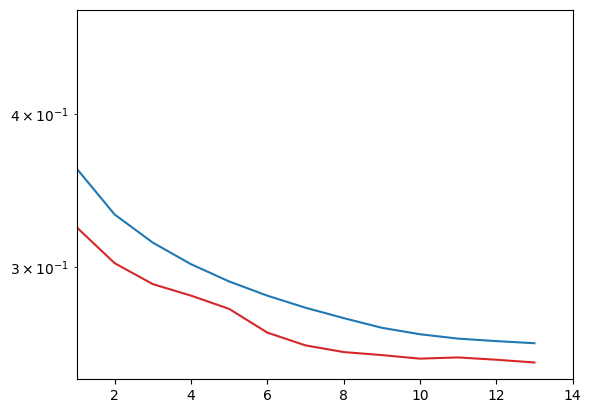

In [ ]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [ ]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-18 04:16:40.008407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step


2024-06-18 04:16:46.511924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
p_valid.numpy()[0]

array([ 4.41540104e-05,  1.17593669e-05,  4.99364276e-05,  1.15849704e-04,
        1.18762283e-04,  1.38168927e-04,  1.31325779e-04,  1.11941738e-04,
        7.62355657e-05,  5.59894341e-05,  4.06329638e-05,  3.11236676e-05,
        2.56126911e-05,  2.11678961e-05,  1.49962994e-05,  1.05332451e-05,
        6.01114352e-06,  8.90657996e-06, -5.86432859e-07,  4.55248142e-06,
        3.29134006e-06,  1.29633768e-06,  1.32082633e-06,  1.02777386e-05,
        1.76192279e-05,  2.03575447e-05,  1.02421570e-05, -1.28409899e-06,
       -6.64042517e-06,  1.97603013e-06,  3.51795970e-06, -4.53778344e-06,
       -2.73701807e-06,  4.17617149e-07, -1.50799410e-05,  2.34765585e-05,
        7.83000655e-05,  9.01033915e-05,  9.75927030e-05,  8.52953681e-05,
        5.26527270e-05,  2.41996422e-05, -4.08920331e-06, -1.48055111e-05,
       -2.86923796e-05, -2.89012558e-05, -2.85687950e-05, -1.64398009e-05,
       -1.43812486e-05, -1.13749088e-05, -1.07844372e-05, -1.60867953e-05,
       -1.64829452e-05, -

In [ ]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();